In [1]:
import stm
import xarray as xr
import dask
import dask.dataframe as dd
import dask.array as da
from pathlib import Path
import pandas as pd
import numpy as np
import re

# dask.config.set(scheduler='synchronous') # Dask debug mode

In [2]:
# memory usage per block
blocksize = 100e6 # in bytes, 100e6 is 100MB

from dask.distributed import Client, LocalCluster
cluster = LocalCluster() 
client = Client(cluster)
client

2023-06-16 13:07:11,720 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-61tuc3mv', purging
2023-06-16 13:07:11,721 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-2f7uwdfr', purging
2023-06-16 13:07:11,721 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ymjzl4y8', purging
2023-06-16 13:07:11,721 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zc7ts8po', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 7.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40545,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 7.58 GiB
Comm: tcp://127.0.0.1:37107,Total threads: 3
Dashboard: http://127.0.0.1:42535/status,Memory: 1.89 GiB
Nanny: tcp://127.0.0.1:45265,


In [ ]:
# p_data = Path('../../data/depsi_products/full-pixel_psi_amsterdam_tsx_asc_t116_v4_ampl_std_H_c16643.csv')
# p_data = Path('../../data/depsi_products/full-pixel_psi_amsterdam_tsx_asc_t116_v4_ampl_std_H_c16643.csv.part')
p_data = Path('../../data/depsi_products/full-pixel_psi_amsterdam_tsx_asc_t116_v4_ampl_std_H_c16643.csv.part.big')

In [ ]:
# # Make a small cut of data, used for prepare the test data, can be skipped
# ddf_small = pd.read_csv(p_data, nrows=200000)
# ddf_small.to_csv(p_data.parent / (p_data.parts[-1]+'.part.big'))

In [ ]:
# # The following is slow (~50 seconds), therefore cannot use dask.delayed for manual block reading
# data = pd.read_csv(p_data, skiprows=2_000_000, nrows=100)
# data

In [ ]:
# # Following does not help dask dataframe determine the chunksize
# headrows = pd.read_csv(p_data, nrows=5)
# ddf = dd.read_csv(p_data, blocksize=blocksize, dtype=headrows.dtypes.to_dict())
# ddf

In [ ]:
# Load csv as Dask DataFrame
ddf = dd.read_csv(p_data, blocksize=blocksize)
ddf

In [ ]:
# # Inspect ddf, can be skipped
# ddf.visualize()
# ddf.columns

In [ ]:
# Compute the chunk sizes per chunk
ddf_pnt_height = ddf['pnt_height']
da_pnt_height = ddf_pnt_height.to_dask_array()
da_pnt_height.compute_chunk_sizes()
chunks = da_pnt_height.chunks # This should be a slightly uneven chunksize per chunk

print(da_pnt_height)
print(da_pnt_height.shape)
print(chunks)

In [ ]:
# Setup a template STM
coords = {
    "space": range(da_pnt_height.shape[0]),
    "time": range(time_shape),
}
stmat = xr.Dataset(coords=coords)
stmat

In [ ]:
# This can potentially be the "from_csv" function for stmtools

# Manuallt create a lookup dict for ts columns
# In the format "Start_String: Variable_Name 
# E.g. d_??????? are deformatin columns, this should be 'd_': 'deformation'
dict_col_name = {'d_': 'deformation', 'a_': 'amplitude', 'h2ph_': 'h2ph'}

dict_temp_da = dict() # Temporary dask array collector
for k in dict_col_name.keys():
    dict_temp_da[k]=[]

# Assine pnt columns
# Temporaly save time-series columns to lists in dict_temp_da
for column in ddf.columns:
    if re.match(re.compile('^pnt_'), column): # Get all the "pnt_" columns
        da_pnt = ddf[column].to_dask_array(lengths=chunks[0])
        stmat = stmat.assign({column: (("space"), da_pnt)})
    elif re.search(re.compile('\d{8}$'), column): # Time series attributs, ends with 8 digit number
        for k, v in dict_col_name.items():
            if re.match(re.compile('^{}'.format(k)), column):
                da_list = dict_temp_da[k]
                da_list.append(ddf[column].to_dask_array(lengths=chunks[0]))
                dict_temp_da[k]=da_list

# Stack dask arrays in dict_temp_da, assign to STM
for k, v in dict_temp_da.items():
    da_list = dict_temp_da[k]
    da_ts = da.stack(da_list) # Stack on time dimension
    stmat = stmat.assign({dict_col_name[k]: (("time", "space"), da_ts)})

# Rearrage space and time order
stmat = stmat.transpose("space", "time")

# Uniform chunking
stmat = stmat.chunk({'space': 10000, 'time':-1})

# Set coordinates
stmat = stmat.rename({'pnt_lat':'lat', 'pnt_lon':'lon'})
stmat = stmat.set_coords(['lat', 'lon'])

stmat


In [ ]:
stmat.to_zarr('stm.zarr')

In [3]:
stmat = xr.open_zarr('stm.zarr')
stmat = stmat.chunk({'space': 10000, 'time':-1})
stmat = stmat.rename({'space':'points'})
stmat

<xarray.Dataset>
Dimensions:                (points: 200000, time: 198)
Coordinates:
    lat                    (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon                    (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
  * points                 (points) int64 0 1 2 3 ... 199997 199998 199999
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
Data variables: (12/25)
    amplitude              (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    deformation            (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    h2ph                   (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    pnt_ampconsist         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_demheight          (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_demheight_highres  (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...                     ...
    pnt_seasonal_sin       (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_defo           (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_height         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_linear         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_quadratic      (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_seasonal       (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>

In [ ]:
# print(stmat['lon'].min().compute())
# print(stmat['lon'].max().compute())
# print(stmat['lat'].min().compute())
# print(stmat['lat'].max().compute())

# import fiona
# with fiona.open(path_polygon) as f:
#     print(f.bounds)

In [4]:
path_polygon = Path('../../data/BAG/bag_light_AMS_WGS84.gpkg')
fields_to_query = ['bouwjaar']

# path_polygon = Path('../../data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg')
# fields_to_query = ['gewascode']
# path_polygon.exists()

In [ ]:
# import geopandas as gpd
# onerow = gpd.read_file(path_polygon, rows=1)
# onerow

In [5]:
stmat = stmat.stm.enrich_from_polygon(path_polygon, fields_to_query)
stmat

<xarray.Dataset>
Dimensions:                (points: 200000, time: 198)
Coordinates:
  * points                 (points) int64 0 1 2 3 ... 199997 199998 199999
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
    lat                    (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon                    (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
Data variables: (12/26)
    amplitude              (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    deformation            (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    h2ph                   (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    pnt_ampconsist         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_demheight          (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_demheight_highres  (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...                     ...
    pnt_std_defo           (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_height         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_linear         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_quadratic      (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_seasonal       (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    bouwjaar               (points) object dask.array<chunksize=(10000,), meta=np.ndarray>

In [6]:
stmat_subset = stmat.stm.subset(method='polygon', polygon=path_polygon)
stmat_subset

<xarray.Dataset>
Dimensions:                (points: 106502, time: 198)
Coordinates:
  * points                 (points) int64 0 1 2 3 ... 199986 199987 199988
  * time                   (time) int64 0 1 2 3 4 5 ... 192 193 194 195 196 197
    lat                    (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon                    (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
Data variables: (12/26)
    amplitude              (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    deformation            (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    h2ph                   (points, time) float64 dask.array<chunksize=(10000, 198), meta=np.ndarray>
    pnt_ampconsist         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_demheight          (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_demheight_highres  (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...                     ...
    pnt_std_defo           (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_height         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_linear         (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_quadratic      (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    pnt_std_seasonal       (points) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    bouwjaar               (points) object dask.array<chunksize=(10000,), meta=np.ndarray>

In [7]:
# Compute the construction year
contextual = stmat_subset['bouwjaar'].compute()
# contextual = stmat_subset['gewascode'].compute()

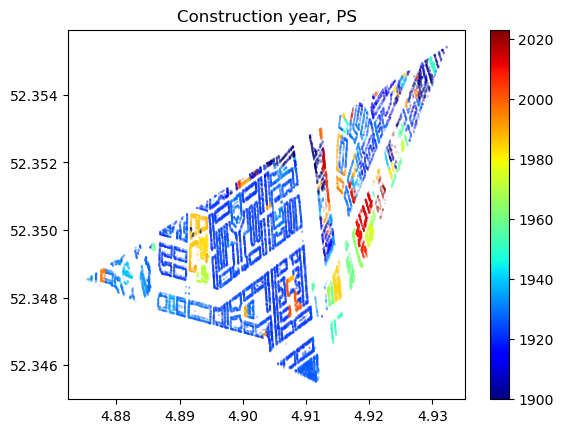

In [8]:
# Visualize results
from matplotlib import pyplot as plt
import matplotlib.cm as cm

colormap = cm.jet

fig, ax = plt.subplots()
plt.title("Construction year, PS")
plt.scatter(stmat_subset.lon.data, stmat_subset.lat.data, c=contextual, s=0.002, cmap=colormap)
plt.clim([1900, 2023])
plt.colorbar()